# TP 1

## Ejercicio 5

Una señal analógica de audio fue grabada utilizando un grabador digital a una frecuencia de $22050 
\mathrm{Hz}$. Esta señal se necesita procesar en un sistema digital y eliminar una componente de ruido en 
alta frecuencia que fue grabada por error y que se puede oír en el archivo `Aranero.wav`. Una 
buena práctica de análisis de señales para poder determinar la frecuencia de muestreo correcta del 
sistema es analizar el espectro de la señal analógica utilizando el comando `pwelch` de Matlab. 
El espectro se muestra a continuación:

_el espectro asdasdas_

La banda de interés del audio se encuentra entre los $0 \mathrm{Hz}$ y los $2 \mathrm{KHz}$,
el resto se considera ruido 
y debe ser eliminado o minimizado en un 90%. Se pide: 

<ol type="A">
  <li>
    Indique en el gráfico espectral la banda de interés y la zona de ruido más 
    problemática. Se recomienda analizar el funcionamiento del comando <code>pwelch</code> en el 
    help de Matlab.
  </li>
  <li>¿Qué frecuencia de muestreo sugiere utilizar para procesar la banda de interés?</li>
  <li>
    ¿Sugiere utilizar filtro antialiasing o no lo considera necesario? En caso de que si, 
    ¿Qué características tendría que cumplir?
  </li>
</ol>

### Resolución

In [1]:
from scipy.io import wavfile
from pathlib import Path
from utils.misc import Audio

resources = Path(".") / "res" / "tp1"

aranero_freq, aranero_dat = wavfile.read(resources / "Aranero.wav")
Audio(aranero_dat.T, aranero_freq);

/tmp/ipykernel_377/1497729326.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  aranero_freq, aranero_dat = wavfile.read(resources / "Aranero.wav")


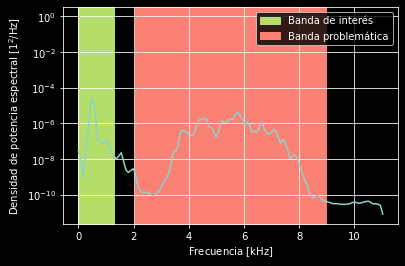

In [2]:
from scipy import signal
from matplotlib import pyplot as plt
from utils.mpl import fill_interval

def mono(xss):
    channels = xss.shape[1]
    return xss.sum(axis=1) / channels

# Convertimos el audio a mono con el promedio del canal izquierdo y derecho
aranero_fs, aranero_powd = signal.welch(mono(aranero_dat), fs=aranero_freq)

fs_khz = aranero_fs/1000
plt.semilogy(fs_khz, aranero_powd)
fill_interval(fs_khz, xmax=1.3, color="C6", label="Banda de interés")
fill_interval(fs_khz, xmin=2.0, xmax=9, color="C3", label="Banda problemática")
plt.xlabel("Frecuencia [$\\mathrm{kHz}$]")
plt.ylabel("Densidad de potencia espectral [$\\mathrm{1^2/Hz}$]")
plt.legend()
plt.grid()

Para diseñar el filtro, se selecciona un filtro Butterworth, cuyo orden mínimo se determina
utilizando la función `buttord` del módulo `signal` del paquete `scipy`. Los demás parámetros
del filtro se definen a continuación.

In [3]:
filt_params = dict(
    # Fin de la banda de paso
    wp = 1300,
    # Comienzo de la banda de rechazo
    ws = 2000,
    # Atenuación (en db) máxima en la banda de paso
    gpass = 1,
    # Atenuación (en db) mínima en la banda de rechazo
    gstop = 80
)

filt_ord, filt_wn = signal.buttord(**filt_params, fs=aranero_freq, analog=False)
# Orden mínimo necesario y frecuencia natural del filtro
filt_ord, filt_wn

(23, 1337.8340405321871)

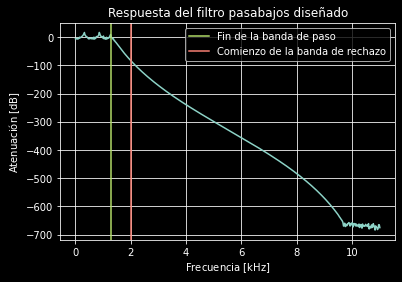

In [4]:
import numpy as np
# Numerador y denominador del filtro IIR.
filt_b, filt_a = signal.butter(
    filt_ord, filt_wn, btype="lowpass", fs=aranero_freq)

to_db = lambda x: 20*np.log10(x)

filt_w, filt_h = signal.freqz(filt_b, filt_a, fs=aranero_freq)
plt.plot(filt_w/1000, to_db(abs(filt_h)))
plt.axvline(filt_params["wp"]/1000,
    label="Fin de la banda de paso", color="C6")
plt.axvline(filt_params["ws"]/1000,
    label="Comienzo de la banda de rechazo", color="C3")
plt.title("Respuesta del filtro pasabajos diseñado")
plt.xlabel("Frecuencia [$\\mathrm{kHz}$]")
plt.ylabel("Atenuación [$\\mathrm{dB}$]")
plt.legend()
plt.grid()


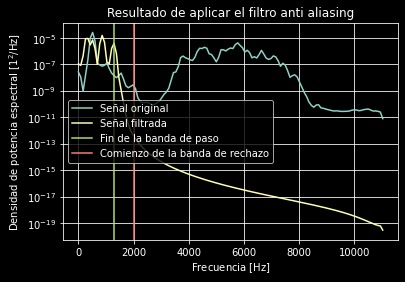

In [5]:
# Se aplica el filtro IIR con las componentes de a y b obtenidas
aranero_filtered = signal.lfilter(filt_b, filt_a, aranero_dat, axis=0)

plt.title("Resultado de aplicar el filtro anti aliasing")
plt.semilogy(*signal.welch(mono(aranero_dat), fs=aranero_freq),
    label="Señal original")
plt.semilogy(*signal.welch(mono(aranero_filtered), fs=aranero_freq),
    label="Señal filtrada")
plt.axvline(filt_params["wp"],
    label="Fin de la banda de paso", color="C6")
plt.axvline(filt_params["ws"],
    label="Comienzo de la banda de rechazo", color="C3")
plt.xlabel("Frecuencia [$\\mathrm{Hz}$]")
plt.ylabel("Densidad de potencia espectral [$\\mathrm{1^2/Hz}$]")
plt.legend()
plt.grid()

Audio(aranero_filtered.T, aranero_freq);

## Ejercicio 6

El siguiente espectro corresponde a la grabación de la vocalización de un ave migratoria conocida 
como Urutaú (_Nyctibius griseus_), en la que se superpuso por error la vocalización de otra especie, 
llamada Arapasú (_Dendrocincla turdina_). El archivo de audio se pone a disponibilidad en el aula 
virtual y se denomina `urutaú.wav` y su espectro se observa en la siguiente Figura. En base a la 
escucha del audio y el espectrograma, se pide:

_el espectrograma_


<ol type="A">
  <li>Determine en el gráfico la banda de interés y la zona de ruido.</li>
  <li>
    Simule en Matlab un sistema de muestreo en donde utilice una frecuencia de muestreo y 
    filtro antialiasing acorde a la banda de interés, es decir, usted deberá fijar una <code>Fs</code> nueva 
    para el sistema. Para el diseño del filtro utilice el comando <code>FDATool</code>, y para el re-muestreo 
    nuevo se sugiere analizar la opción del comando <code>resample</code> o bien otra alternativa más 
    directa, deberá analizarlo usted.
  </li>
  <li>
    Utilizando el comando <code>sound</code> escuche la señal muestreada con y sin filtro antialiasing
    ¿escucha algún efecto? en caso de que si ¿a qué se debe y de donde proviene?
  </li>
  <li>
    Grafique, utilizando el comando <code>pwelch</code> los siguientes espectros y analícelos:
    <ul>
      <li>Señal original.</li>
      <li>Señal filtrada con el filtro antialiasing.</li>
      <li>Señal muestreada con filtro antialiasing.</li>
      <li>Señal muestreada sin filtro antialiasing.</li>
    </ul>
  </li>
  <li>
    En base a la nueva frecuencia de muestreo que eligió, responda y justifique:
    ¿Es obligatorio el uso de un filtro antialiasing? 
  </li>
</ol>

### Resolución

In [6]:
from numericalunits import Hz, kHz

urutau_freq, urutau_dat = wavfile.read(resources / "urutau.wav")
urutau_freq = urutau_freq * Hz
Audio(urutau_dat.T, urutau_freq/Hz);

/tmp/ipykernel_377/4182536711.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  urutau_freq, urutau_dat = wavfile.read(resources / "urutau.wav")


In [7]:
urutau_freq/kHz

22.05

In [8]:
filt_params = dict(
    # Fin de la banda de paso
    wp = 1.3*kHz,
    # Comienzo de la banda de rechazo
    ws = 2*kHz,
    # Atenuación (en db) máxima en la banda de paso
    gpass = 1,
    # Atenuación (en db) mínima en la banda de rechazo
    gstop = 80
)

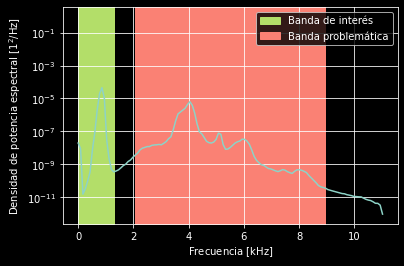

In [9]:
# Convertimos el audio a mono con el promedio del canal izquierdo y derecho
urutau_fs, urutau_powd = signal.welch(mono(urutau_dat), fs=urutau_freq)

fs_khz = urutau_fs/kHz
plt.semilogy(fs_khz, urutau_powd/(1/Hz))
fill_interval(fs_khz, xmax=filt_params["wp"]/kHz,
    color="C6", label="Banda de interés")
fill_interval(fs_khz, xmin=filt_params["ws"]/kHz, xmax=9,
    color="C3", label="Banda problemática")
plt.xlabel("Frecuencia [$\\mathrm{kHz}$]")
plt.ylabel("Densidad de potencia espectral [$\\mathrm{1^2/Hz}$]")
plt.legend()
plt.grid()

El comando `resample` de matlab usa un filtro pasa bajos correspondiente a la nueva frecuencia de muestreo.
la función [`scipy.signal.decimate`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.decimate.html#scipy.signal.decimate) realiza una operación similar antes de tomar muestras entre medio de
la señal original.

In [10]:
from math import floor
urutau_sub_step = floor(urutau_freq/(2*filt_params["wp"]))
urutau_sub_freq = urutau_freq/urutau_sub_step

urutau_sub_dat = urutau_dat[::urutau_sub_step]
urutau_dec_dat = signal.decimate(urutau_dat, urutau_sub_step, axis=0)
# Se realiza el filtrado seguido del submuestreo
urutau_filt_dat = signal.lfilter(
    *signal.butter(
        *signal.buttord(**filt_params, fs=urutau_freq, analog=False),
        btype="lowpass", fs=urutau_freq),
    urutau_dat, axis=0
)[::urutau_sub_step]

(urutau_sub_step, urutau_sub_freq/kHz)

(8, 2.75625)

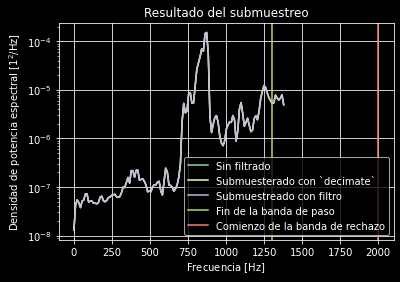

In [11]:
plt.title("Resultado del submuestreo")

for dat, label in [
    (urutau_sub_dat, "Sin filtrado"),
    (urutau_dec_dat, "Submuesterado con `decimate`"),
    (urutau_filt_dat, "Submuestreado con filtro")
]:
    fs, dps = signal.welch(mono(urutau_sub_dat), fs=urutau_sub_freq)
    plt.semilogy(fs/Hz, dps/(1/Hz), label=label)

plt.axvline(filt_params["wp"]/Hz,
    label="Fin de la banda de paso", color="C6")
plt.axvline(filt_params["ws"]/Hz,
    label="Comienzo de la banda de rechazo", color="C3")
plt.xlabel("Frecuencia [$\\mathrm{Hz}$]")
plt.ylabel("Densidad de potencia espectral [$\\mathrm{1^2/Hz}$]")
plt.legend()
plt.grid()

Audio original

In [18]:
Audio(urutau_dat.T, urutau_freq/Hz);

* Audio tomando muestras cada $n$ períodos
* Audio afectado por `decimate`
* Audio filtrado y luego tomando muestras cada $n$ períodos

In [17]:
from IPython.display import display
display = lambda _: None

for dat in [
    urutau_sub_dat,
    urutau_dec_dat,
    urutau_filt_dat
]:
    display(Audio(
        signal.resample(dat, len(urutau_dat)).T,
        urutau_freq/Hz
    ))